# Heuristic Mixture Model for Named Entity Recognition

This notebook serves to present the implementation of a Heuristic Mixture Model for Named Entity Recognition (NER). 

**Purpose and Scope:** This notebook presents a detailed exploration and implementation of a heuristic mixture model aimed at enhancing Named Entity Recognition (NER) capabilities. Named Entity Recognition is a crucial task in the field of Natural Language Processing (NLP) that involves identifying and classifying key information in text into predefined categories such as names of people, organizations, locations, etc.

**Goal:** The primary goal of this notebook is to implement a Heuristic Mixture Model for Named Entity Recognition. The model is designed to leverage the strengths of both rule-based and machine learning approaches to improve the overall performance of NER systems.

**Approach:** The approach involves heavy feature engineering and the creation of a custom dataset to train the model. The model is then evaluated on a test set to assess its performance.

An overview of the notebook is as follows:

**NoteBook Overview:**
1. [Introduction](#1-introduction)
    * [Other Approaches](#11-other-approaches)
    * [Knowledge from EDA](#12-knowledge-from-eda)
2. [Data Preprocessing](#2-data-preprocessing)
3. [Feature Engineering](#3-feature-engineering)
    * [Dataset Feature building](#data-building)
    * [Feature Engineering](#preceeding-words-analysis-on-xtrain)
    * [Creating Dataframes](#creating-dfs)
4. [Modeling](#4-modeling)
5. [Evaluation](#5-evaluation)
6. [Conclusion](#6-conclusion)


# 1. Introduction

## 1.1 Other Approaches

## 1.2 Knowledge from EDA

# 2. Data Preprocessing

Firstly, we load the required libraries and the data.

In [4]:
import json
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
from names_dataset import NameDataset
from tqdm import tqdm
from spacy.tokenizer import Tokenizer
import spacy
from spacy.lang.en import English
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
# nlp = spacy.load("en_core_web_sm")
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score

/Users/augusttollerup/Documents/KSEM2/ABA/PII_data_detection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
ner_model = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)

### Pre-Note
Token labels are presented in BIO (Beginning, Inner, Outer) format. The PII type is prefixed with “B-” when it is the beginning of an entity. If the token is a continuation of an entity, it is prefixed with “I-”. Tokens that are not PII are labeled “O”.

In [7]:
file_path = "../data/train.json"

with open(file_path, "r") as file:
    data = json.load(file)

df = pd.DataFrame(data)

We check how the data is structured. Note that each row contains the full text and then arrays of the tokens, trailling_whitespace and labels.

In [8]:
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


# 3. Feature Engineering

We can explode the labels to see the distribution of the labels in the dataset.

In [9]:
tokens_exploded = df.tokens.explode().reset_index(drop=True)
labels_exploded = df.labels.explode().reset_index(drop=True)
labels_exploded.value_counts()

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64

We can see how different labels are represented int the data. From the BIO format we get a fragmented version of the original text labels. An example of this is how adresses are represented in different 'bites' of the original address. This makes a 'simple' model much harder to implement.

In [10]:
ids = labels_exploded[labels_exploded == 'I-STREET_ADDRESS'].index
tokens_exploded[ids]

861200           Smith
861201         Centers
861202             Apt
861203               .
861204             656
861205              \n
861206     Joshuamouth
861207               ,
861208              RI
861209           95963
1445331          Erika
1445332         Bypass
1445333            Apt
1445334              .
1445335            419
1445336             \n
1445337    Andreahaven
1445338              ,
1445339             IL
1445340          54207
Name: tokens, dtype: object

For creating regex features, we experiment with different regex patterns and tune it to have the highest precision. We can see that the regex features are very useful in identifying the different types of PII.

In [13]:
reg = r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
b_ids = labels_exploded.str.contains('I-STREET_ADDRESS')
specific_id = b_ids.loc[ids]
ids_in_tokens = tokens_exploded.str.contains(reg)

print('Regex finding Ids in label specific: ', specific_id.sum())
print('Regex finding Ids in all tokens: ', ids_in_tokens.sum())
print()
print('Accuracy Regex finding Ids in label specific: ', specific_id.sum() / len(specific_id))
# We calculate the percentage of ids we would have classified wrongly in the total amount of tokens
print('Error of missclassification in whole', ids_in_tokens.sum() / len(ids_in_tokens))

Regex finding Ids in label specific:  20
Regex finding Ids in all tokens:  246

Accuracy Regex finding Ids in label specific:  1.0
Error of missclassification in whole 4.927358517209601e-05


## Model Definition
Our objective is to construct a model characterized by simplicity and efficiency. This model will scrutinize each token within a string, subjecting it to a series of evaluative functions. Should any of these functions affirmatively identify a token as significant, that token is then designated as a keyword. Subsequently, the model outputs both the keyword and its corresponding index within the input string.

The PiiModel class has been meticulously designed to analyze text data for the purpose of identifying personally identifiable information (PII) and other significant tokens. Employing a robust amalgamation of regular expression (regex) patterns, named entity recognition (NER) techniques, and tailored heuristics, the model adeptly pinpoints and extracts critical personal details such as names, email addresses, and phone numbers. By integrating these components, the model employs a sophisticated mixture of methods to effectively recognize and classify various types of significant information embedded within text data.

Features generated by PiiModel:
- **Token Features:** Each token is analyzed to determine if it fits certain patterns such as emails, phone numbers, addresses, personal IDs, and URLs.
- **Name Analysis:** Checks if tokens are recognized as first or last names based on a given dataset with country-wise name rankings and thresholds.
- **Punctuation Marks:** Identifies whether a token is a punctuation mark.
- **Capitalization:** Determines if a token starts with an uppercase letter.
- **Numerical Analysis:** Calculates the percentage of numeric characters in a token.
- **Word Length:** Measures the length of each token.
- **Stop Words:** Flags tokens that are common stop words.
- **Contextual Named Entity Recognition (NER):** Analyzes the text for entities like persons and locations, contextual to the token being analyzed.
- **Windowed Neighboring Features:** For each token, checks surrounding tokens up to five positions away to the left and right for all aforementioned features.
- **Contextual Precedence Check:** For significant tokens related to specific labels, checks if preceding tokens (up to two positions before) are significant for that label.

Data Frame Building: Structures all tokens into a DataFrame with corresponding labels and features, allowing for easy manipulation and analysis.

In [83]:
names = NameDataset()

In [84]:
names.first_names.get("August")

{'country': {'AT': 0.071,
  'BE': 0.044,
  'DE': 0.059,
  'DK': 0.052,
  'MY': 0.052,
  'NL': 0.071,
  'SA': 0.047,
  'SE': 0.069,
  'US': 0.341,
  'ZA': 0.195},
 'gender': {'F': 0.141, 'M': 0.859},
 'rank': {'AT': 351,
  'BE': 1628,
  'DE': 1997,
  'DK': 248,
  'MY': 6402,
  'NL': 1910,
  'SA': 14254,
  'SE': 306,
  'US': 2869,
  'ZA': 2723}}

In [85]:
import re

def tokenizer(text):
    # Remove excessive line breaks or spaces
    text = re.sub('(\r\n){2,}', ' ', text)
    
    # Convert the text to lowercase and split into tokens
    tokens = text.lower().split(" ")
    
    return tokens

class PiiModel:
    def __init__(self, text: str = None, 
                 names_dataset = None, tokens: list = None, 
                 significant_tokens: dict = None, 
                 dataframe: pd.DataFrame = None, full_text: str = None):
        self.text = text
        self.names = names_dataset
        self.tokens = tokens
        self.tokenizer = tokenizer
        self.name_rank_threhsold = 1500
        self.country_threshold = 0.01
        self.significant_tokens = significant_tokens
        self.feature_df = pd.DataFrame()
        self.input_df = dataframe
        self.full_text = full_text
        pass
    
    def get_firstname(self, name: str) -> bool:
        found_name = self.names.first_names.get(name.capitalize())

        if not found_name:
            return False
        country = found_name["country"]
        # If any of the countries has a higher percentage than the threshold and the rank is lower than the threshold
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False

    
    def get_lastname(self, lastname: str) -> bool:
        found_name = self.names.last_names.get(lastname.capitalize())
        # we check if the max country is higher than a threshold then we say it is a valid name
        if not found_name:
            return False
        country = found_name["country"]
        if any(value > self.country_threshold for value in country.values()) and any(rank < self.name_rank_threhsold for rank in found_name["rank"].values()):
            return True
        return False
    
    def get_email_regex(self):
        return r'[\w\.-]+@[\w\.-]+'
    
    def get_phone_number_regex(self):
        return r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    
    def get_address_regex(self):
        return r'\d{1,5}\s\w.\s(\b\w*\b\s){1,2}\w*\.'
    
    def get_personal_id_regex(self):
        return r'\d{6,12}\b|\b[a-zA-Z]+\d{2,}'
    
    def get_url_personal_regex(self):
        return r'https?://[\w\.-]+'
    
    def numb_percent(self, text: str) -> float:
        return sum(c.isdigit() for c in text) / len(text)
    
    def word_length(self, text: str) -> int:
        return len(text)
    
    def is_punctuationmark(self, text: str) -> bool:
        return text in [".", ",", "!", "?", ";", ":"]
    
    def stop_words(self, text: str) -> bool:
        return text in nlp.Defaults.stop_words
    
    def capitalize(self, text: str) -> bool:
        return text[0].strip().isupper()
    
    def NER_ingest(self, text: str):
        return ner_model(text)

    def contextual_ner_person(self, text: str) -> bool:
        return text in list(self.NER_persons)
    
    def contextual_ner_location(self, text: str) -> bool:
        return text in (self.NER_locations)
    
    def check_preceding_contextual_tokens(self, index, label):
        # Extract relevant tokens directly, avoiding repeated DataFrame row access
        start_index = max(0, index-2)
        tokens_to_check = self.feature_df['token'][start_index:index]
        
        # Get the set of significant tokens for the label, defaulting to an empty set if not found
        significant_tokens_set = self.significant_tokens.get(label, set())
        
        # Check if any of the tokens to check are in the significant tokens set
        return any(token in significant_tokens_set for token in tokens_to_check)

    
    def build_df(self, text: str = "", tokens: list = None, labels: list = None) -> pd.DataFrame:
        token_indices = self.tokens
        if not self.tokens and text != "":
            token_indices = self.tokenizer(text)
            self.tokens = token_indices
        if tokens:
            token_indices = tokens
        elif self.input_df is not None:
            token_indices = self.input_df["tokens"]
        self.feature_df["token"] = token_indices

        self.feature_df['labels'] = labels
        return None

    def build_features(self) -> list[tuple[int, str]]:
        # Computing Features
        self.feature_df['first_name'] = self.feature_df['token'].apply(self.get_firstname)
        self.feature_df['last_name'] = self.feature_df['token'].apply(self.get_lastname)
        self.feature_df['email'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_email_regex(), x)))
        self.feature_df['phone_number'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_phone_number_regex(), x)))
        self.feature_df['address'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_address_regex(), x)))
        self.feature_df['personal_id'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_personal_id_regex(), x)))
        self.feature_df['url'] = self.feature_df['token'].apply(lambda x: bool(re.match(self.get_url_personal_regex(), x)))
        self.feature_df['capitalized'] = self.feature_df['token'].apply(lambda x: self.capitalize(x))
        self.feature_df['numb_percent'] = self.feature_df['token'].apply(self.numb_percent)
        self.feature_df['word_length'] = self.feature_df['token'].apply(self.word_length)
        self.feature_df['norm_index'] = self.feature_df.index / len(self.feature_df)
        self.feature_df['is_punctuation'] = self.feature_df['token'].apply(self.is_punctuationmark)
        self.feature_df['stop_word'] = self.feature_df['token'].apply(self.stop_words)

        ingested = self.NER_ingest(self.full_text)

        self.NER_persons = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'PER']).explode().reset_index(drop=True)
        self.NER_locations = pd.Series([entity['word'] for entity in ingested if entity['entity_group'] == 'LOC']).explode().reset_index(drop=True)

        self.feature_df['contextual_ner_person'] = self.feature_df['token'].apply(self.contextual_ner_person)
        self.feature_df['contextual_ner_location'] = self.feature_df['token'].apply(self.contextual_ner_location)

        # Window
        for i in range(1, 6):
            self.feature_df[f'r_neighboured_email_{i}'] = self.feature_df['email'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_email_{i}'] = self.feature_df['email'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_phone_number_{i}'] = self.feature_df['phone_number'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_address_{i}'] = self.feature_df['address'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_address_{i}'] = self.feature_df['address'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_personal_id_{i}'] = self.feature_df['personal_id'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_url_{i}'] = self.feature_df['url'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_url_{i}'] = self.feature_df['url'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_capitalized_{i}'] = self.feature_df['capitalized'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_numb_percent_{i}'] = self.feature_df['numb_percent'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_punctuation_{i}'] = self.feature_df['is_punctuation'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_stop_word_{i}'] = self.feature_df['stop_word'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_word_length_{i}'] = self.feature_df['word_length'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_first_name_{i}'] = self.feature_df['first_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_last_name_{i}'] = self.feature_df['last_name'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_person_{i}'] = self.feature_df['contextual_ner_person'].shift(i).fillna(False)
            self.feature_df[f'r_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(-i).fillna(False)
            self.feature_df[f'l_neighboured_contextual_ner_location_{i}'] = self.feature_df['contextual_ner_location'].shift(i).fillna(False)


        if self.input_df is not None:
            self.feature_df["text_index"] = self.input_df.text_index
        # Add a new feature for each label based on contextual tokens
        for label in self.significant_tokens.keys():
            feature_name = f'{label.lower()}_contextual_presence'
            self.feature_df[feature_name] = [self.check_preceding_contextual_tokens(i, label) for i in range(len(self.feature_df))]


        return None


## Data building
We can then start building the data for the model. We will split the data into training and testing data. We will then use the PiiModel class to generate the features for the data.

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_split = df.iloc[:100]

X_train, X_test, y_train, y_test = train_test_split(df_split, 
                                                    df_split.labels, 
                                                    test_size=0.33, 
                                                    random_state=42)

### Preceeding Words analysis on Xtrain:
We can see that the preceeding words are very important in determining the type of PII. For example, if the word 'email' is present in the preceeding words, the token is most likely an email. We can use this information to create a feature that checks for the presence of certain words in the preceeding words.

In [87]:
dfs_analysis = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names)
    model.build_df(tokens=tokens, labels=labels)
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_analysis.append(model.feature_df)

X_analysis = pd.concat(dfs_analysis, axis=0)
X_analysis.fillna(0, inplace=True)


100%|██████████| 67/67 [00:00<00:00, 677.54it/s]


In [88]:
_analysis_df = X_analysis[['token', 'labels']].reset_index()

In [89]:
_analysis_df.labels.unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL',
       'B-EMAIL', 'B-ID_NUM'], dtype=object)

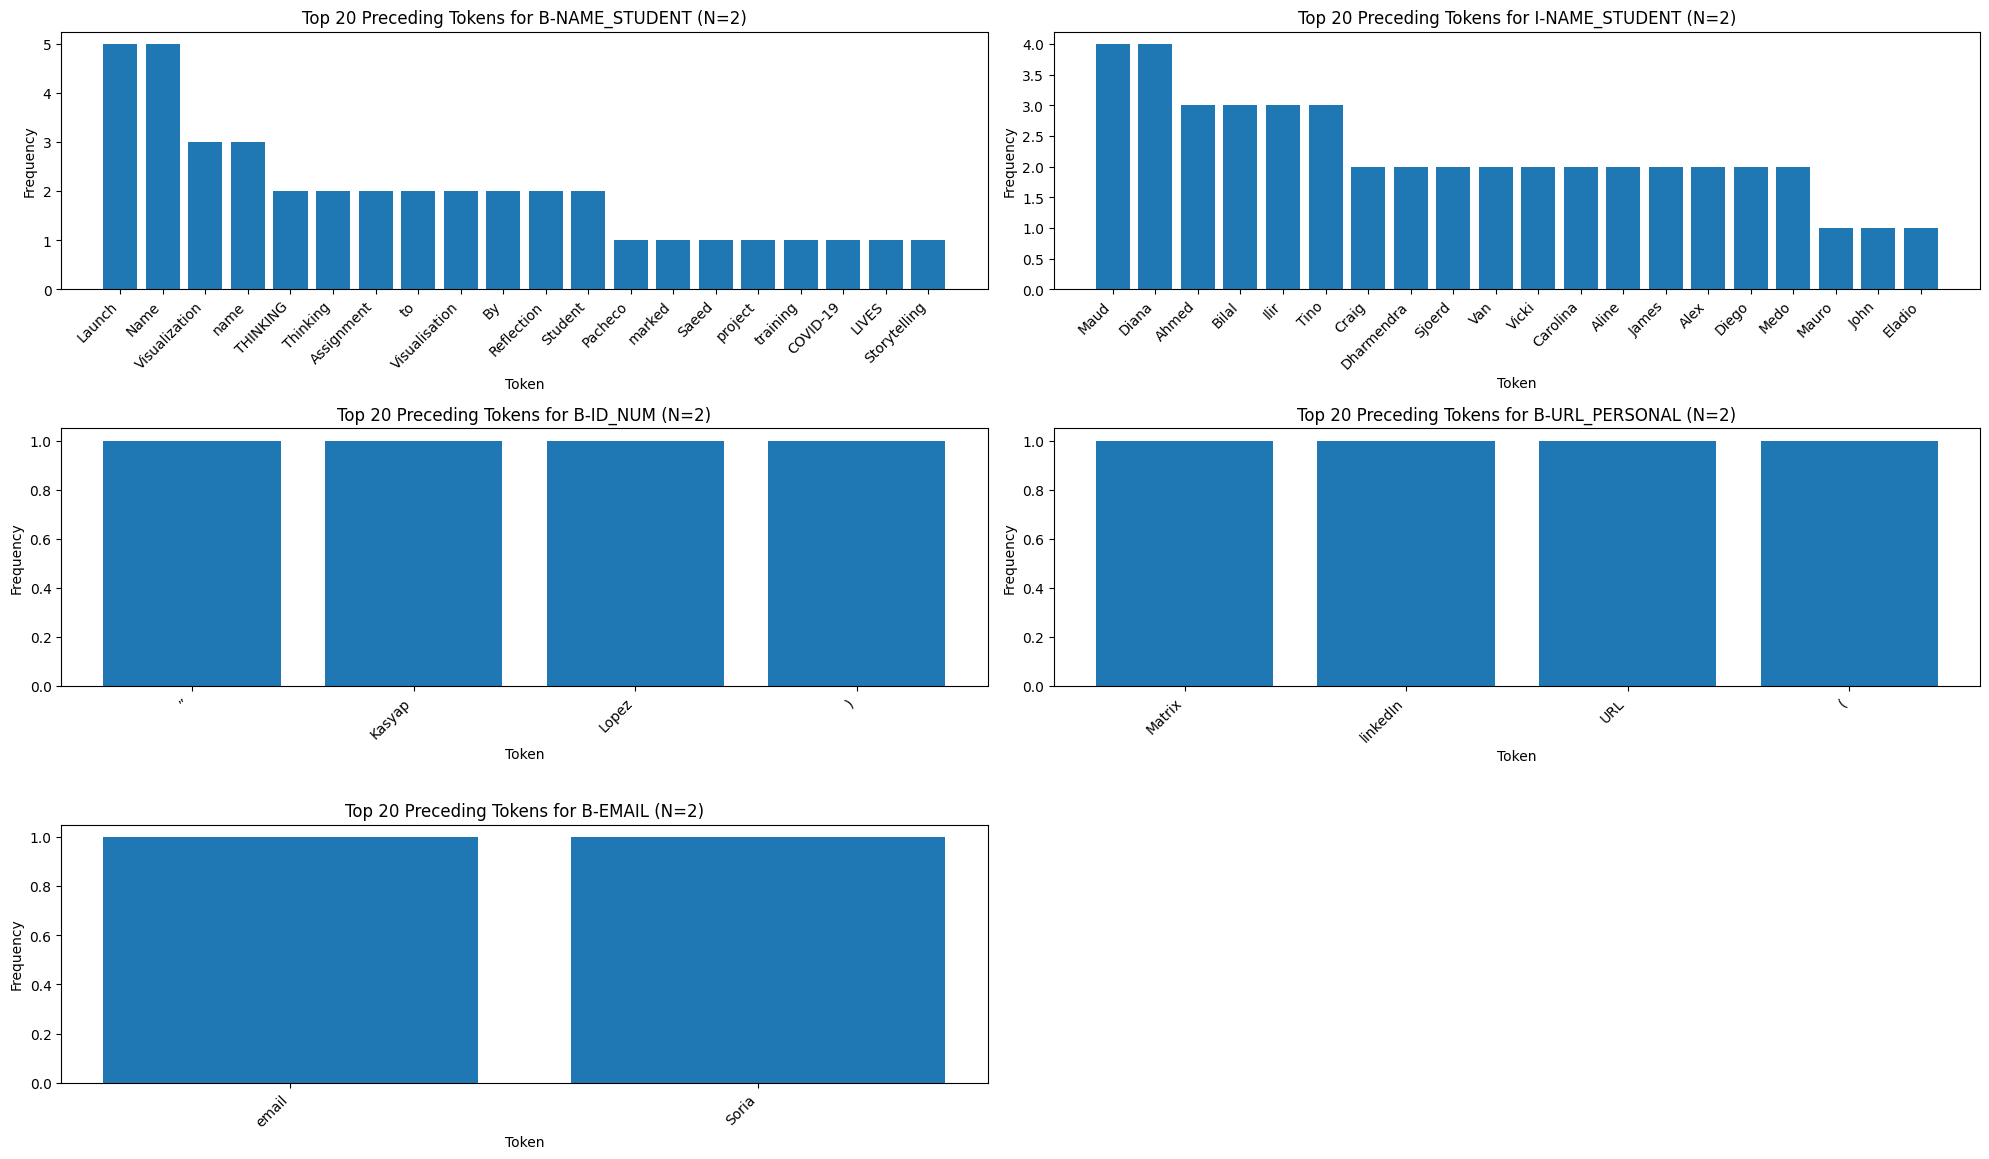

In [90]:
def get_preceding_tokens(row_index, N, dataframe):
    # Calculate the start index to avoid negative indexing
    start_index = max(0, row_index - N)
    # Extract preceding N tokens, if the row_index is not at the very beginning
    if start_index < row_index:
        return dataframe.iloc[start_index:row_index]['token'].tolist()
    else:
        return []


N = 2  # Example: Look 2 tokens back
labels_of_interest = ['B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-ID_NUM',
       'B-URL_PERSONAL', 'B-EMAIL', 'B-USERNAME', 'I-URL_PERSONAL',
       'I-ID_NUM', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS']

# Initialize a dictionary to hold token frequencies for each label
token_frequencies_by_label = {label: {} for label in labels_of_interest}

for label in labels_of_interest:
    # Filter rows for the specific label
    label_indices = _analysis_df[_analysis_df['labels'] == label].index
    
    # Collect preceding tokens for each occurrence of the label
    for index in label_indices:
        preceding_tokens = get_preceding_tokens(index, N, _analysis_df)
        for token in preceding_tokens:
            if token in token_frequencies_by_label[label]:
                token_frequencies_by_label[label][token] += 1
            else:
                token_frequencies_by_label[label][token] = 1


from collections import defaultdict

# This dictionary will count the occurrences of each token across labels
token_occurrences_across_labels = defaultdict(int)

# Count occurrences of each token across different labels
for label, frequencies in token_frequencies_by_label.items():
    for token in frequencies.keys():
        token_occurrences_across_labels[token] += 1

# Identify tokens that appear in more than one label's frequency dictionary
common_tokens = {token for token, count in token_occurrences_across_labels.items() if count > 1}


# Remove common tokens from each label's frequency dictionary
filtered_token_frequencies_by_label = {
    label: {token: frequency for token, frequency in frequencies.items() if token not in common_tokens}
    for label, frequencies in token_frequencies_by_label.items()
}


plt.figure(figsize=(20, 15))

for i, (label, frequencies) in enumerate(filtered_token_frequencies_by_label.items(), 1):
    # Sort the frequencies dictionary by value and get the top 20 tokens
    try:
        top_tokens = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:20]
        tokens, counts = zip(*top_tokens)  # Unzip the token-count pairs
        
        # Plot
        plt.subplot(4, 2, i)  # Adjust grid size based on the number of labels
        plt.bar(tokens, counts)
        plt.title(f'Top 20 Preceding Tokens for {label} (N={N})')
        plt.xticks(rotation=45, ha="right")
        plt.ylabel('Frequency')
        plt.xlabel('Token')
    except:
        pass
    
plt.tight_layout()
plt.show()

### Creating DFs
We can then create the dataframes for the training and testing data. We can then use these dataframes to train the model.

In [112]:
dfs_train = []

for i in tqdm(range(X_train.shape[0])):
    tokens, labels = X_train.tokens.iloc[i], y_train.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_train.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_train.append(model.feature_df)

X_train = pd.concat(dfs_train, axis=0)
X_train.fillna(0, inplace=True)


100%|██████████| 67/67 [00:24<00:00,  2.73it/s]


In [113]:
dfs_test = []

for i in tqdm(range(X_test.shape[0])):
    tokens, labels = X_test.tokens.iloc[i], y_test.iloc[i]
    model = PiiModel(text=tokens, names_dataset=names, significant_tokens=token_frequencies_by_label, full_text=X_test.full_text.iloc[i])
    model.build_df(tokens=tokens, labels=labels)
    model.build_features()
    
    # Reset index and drop the old index to ensure unique indices
    model.feature_df.reset_index(drop=True, inplace=True)
    # drop duplicate columns
    model.feature_df = model.feature_df.loc[:,~model.feature_df.columns.duplicated()]
    
    # Append the DataFrame to the list
    dfs_test.append(model.feature_df)

X_test = pd.concat(dfs_test, axis=0)
X_test.fillna(0, inplace=True)


100%|██████████| 33/33 [00:12<00:00,  2.68it/s]


In [93]:
# Find unique entries in y_test
X_test['labels'].unique()

array(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL'],
      dtype=object)

# 4. Modeling

In this project we use the Random Forest Classifier to classify the tokens. We can then train the model and evaluate it on the test data.


In [95]:
from sklearn.metrics import fbeta_score
model = RandomForestClassifier(n_jobs=-1)
model.fit(X_train.drop(columns=["token", "labels"]), y_train.explode())

RandomForestClassifier(n_jobs=-1)

# 5. Evaluation

In [96]:
model.score(X_test.drop(columns=["token", "labels"]), y_test.explode())

0.9979926510615134

In [97]:
predictions = model.predict(X_test.drop(columns=["token", "labels"]))

We quickly check the distribution of predicted labels in the test data. We look for a distribution that is similar to the training data.

In [98]:
pd.Series(predictions).value_counts()

O                 29338
B-NAME_STUDENT       26
I-NAME_STUDENT       22
B-URL_PERSONAL        6
Name: count, dtype: int64

In [99]:
pd.Series(y_test.explode()).value_counts()

labels
O                 29291
B-NAME_STUDENT       63
I-NAME_STUDENT       37
B-URL_PERSONAL        1
Name: count, dtype: int64

In [100]:
df_results = pd.DataFrame({"predictions": pd.Series(predictions).reset_index(drop=True), 
                           "labels": y_test.explode().reset_index(drop=True), 
                           "tokens": X_test.token.explode().reset_index(drop=True)})
df_results.head()

,predictions,labels,tokens
0,O,O,Guayaquil
1,O,O,","
2,O,O,September
3,O,O,24
4,O,O,","


We can then calculate an accuracy score for the model. In the accuracy metric we disregard the 'O' labels as they are the most common and can skew the results.

In [101]:
accuracy = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O")) & 
    (df_results['predictions'] == df_results['labels'])
].shape[0] / df_results[(df_results['predictions'] != "O") | (df_results['labels'] != "O")].shape[0]

In [102]:
accuracy

0.4485981308411215

In [47]:
non_O_rows = df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))
]
non_O_rows

,predictions,labels,tokens
3,B-NAME_STUDENT,B-NAME_STUDENT,Rania
4,I-NAME_STUDENT,I-NAME_STUDENT,Mohammed
240,B-URL_PERSONAL,O,https://www.youtube.com/watch?v=Nj-hdQMa3uA
1994,B-NAME_STUDENT,B-NAME_STUDENT,Mohamed
1995,I-NAME_STUDENT,I-NAME_STUDENT,Mahmod
...,...,...,...
132950,O,B-NAME_STUDENT,Tino
132951,O,I-NAME_STUDENT,Lopez
132983,O,B-NAME_STUDENT,Hlengiwe
133773,B-NAME_STUDENT,B-NAME_STUDENT,Bruno


In [104]:
fbeta_score(df_results['labels'], df_results['predictions'], average='micro', beta=5)

0.9979926510615134

In [105]:
quick_anal = df_results
quick_anal = pd.concat([quick_anal, X_test['contextual_ner_person'].reset_index(drop=True)], axis=1)


In [106]:
quick_anal["labels"].value_counts()

labels
O                 29291
B-NAME_STUDENT       63
I-NAME_STUDENT       37
B-URL_PERSONAL        1
Name: count, dtype: int64

In [ ]:
quick_anal[quick_anal['contextual_ner_person'] == True][['labels', 'contextual_ner_person']].value_counts()

In [ ]:
quick_anal[(quick_anal['contextual_ner_person'] == True) & 
           ((quick_anal['labels'] == "B-NAME_STUDENT")
            | (quick_anal['labels'] == "I-NAME_STUDENT"))]

**Prediction Pairs** 

In [ ]:
df_results[
    ((df_results['predictions'] != "O") | (df_results['labels'] != "O"))][["predictions", "labels"]].value_counts()

In [ ]:
df_results[
    ((df_results['labels'] == "I-NAME_STUDENT"))][["predictions", "labels"]].value_counts()

In [ ]:
X_test.iloc[28886][:10]

In [ ]:
df_results[((df_results['predictions'] == "O") & (df_results['labels'] == "B-URL_PERSONAL"))]

In [ ]:
# print feature importance
importances = model.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(X_train.drop(columns=["token", "labels"]).columns, importances)
plt.xticks(rotation=90)
plt.show();

In [154]:
# we create incremented token ids 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... to count tokens within a text
X_test_og["token_ids"] = X_test_og.tokens.apply(lambda x: list(range(len(x))))

In [156]:
token_ids = X_test_og.explode('token_ids')["token_ids"]
document_ids = X_test_og.explode('tokens')["document"]
df_results["document_id"] = document_ids.reset_index(drop=True)
df_results["token_id"] = token_ids.reset_index(drop=True)
df_results[df_results['labels'] != "O"]

,predictions,labels,tokens,document_id,token_id
10,B-NAME_STUDENT,B-NAME_STUDENT,Adam,2722,10
11,I-NAME_STUDENT,I-NAME_STUDENT,Filip,2722,11
113,O,B-NAME_STUDENT,Saman,2722,113
114,O,I-NAME_STUDENT,Mojica,2722,114
137,O,B-NAME_STUDENT,Saman,2722,137
...,...,...,...,...,...
28181,O,I-NAME_STUDENT,Collet,1290,557
28225,O,B-NAME_STUDENT,Olivier,1290,601
28226,O,I-NAME_STUDENT,Collet,1290,602
28304,B-NAME_STUDENT,B-NAME_STUDENT,Susan,2745,2


# 6. Conclusion